In [1]:
import torch_geometric
from torch_geometric.datasets import MD17
from torch_geometric.nn import GCNConv
from torch.nn import Module, Embedding, Linear, MSELoss, Tanh
from torch.optim import Adam
from torch_geometric.nn import global_mean_pool
import torch
import matplotlib.pyplot as plt
from torch import Tensor

In [2]:
# load in dataset
dataset = MD17(root='../data/benzene', name='benzene', transform=None, pre_transform=None)

/usr/local/Caskroom/miniconda/base/envs/GDL/lib/python3.11/site-packages/torch_geometric/data/dataset.py:239: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


In [104]:
class ToyGCN(Module):
    def __init__(self):
        super().__init__()
        
        # initialize layers
        self.embedding = Embedding(118, 8)
        self.conv = GCNConv(8, 8)
        self.lin = Linear(8, 1)
        self.non_linearity = Tanh()

    # define forward pass
    def forward(self, data):
        # get relevant parts from data arg
        edge_index = data.edge_index        
        pos = data.pos
        
        edge_attr = []
        for src, tar in zip(edge_index[0], edge_index[1]):
            dist = torch.dist(pos[src.item()], pos[tar.item()])
            edge_attr.append(dist)
        edge_attr = torch.stack(edge_attr)
        
        # initialize E_hat
        E_hat = data.z

        # embed E_hat and put it through embedding, conv, linear layers
        E_hat = self.embedding(E_hat)
        
        E_hat = self.conv(E_hat, edge_index, edge_attr)
        E_hat = self.non_linearity(E_hat)
        
        E_hat = self.lin(E_hat)
        E_hat = self.non_linearity(E_hat)
        
        # combine representations of all nodes
        # into single graph-level prediction
        E_hat = global_mean_pool(E_hat, data.batch)
        E_hat = E_hat.sum()
        
        return E_hat

In [105]:
model = ToyGCN()
model.train()

loss_fn = MSELoss()
optimizer = Adam(model.parameters(), 0.001)

In [106]:
mini_dataset = dataset[:100]
data = mini_dataset[0]

In [107]:
E = data.energy
F = data.force
losses = []
for i in range(1000):
    E_hat, F_hat = model(data)
    print(E_hat)

    # calculate loss
    E_loss = loss_fn(E_hat, E)
    F_elementwise_error = F_hat - F
    F_elementwise_squared_error = torch.square(F_elementwise_error)
    F_atomwise_error_magnitude = torch.sum(F_elementwise_squared_error, dim=1)
    F_loss = torch.div(torch.sum(F_atomwise_error_magnitude), data.size()[0])

    # loss = E_loss + F_loss
    loss = E_loss
    losses.append(loss.item())

    loss.backward()

    optimizer.step()

E_hat, F_hat = model(data)
E = data.energy
F = data.force

print(f'energy error: {E_hat.item() - E.item()}')
print(f'force error: {torch.sum(F_hat - F)}')

['global_mean_pool: tensor([[-0.1922]], grad_fn=<MeanBackward1>)']
['sum: -0.19224685430526733']
['backward: -0.19224685430526733']
tensor(-0.1922, grad_fn=<SumBackward0>)
['global_mean_pool: tensor([[-0.1825]], grad_fn=<MeanBackward1>)']
['sum: -0.18249063193798065']
['backward: -0.18249063193798065']
tensor(-0.1825, grad_fn=<SumBackward0>)
['global_mean_pool: tensor([[-0.1730]], grad_fn=<MeanBackward1>)']
['sum: -0.17295126616954803']
['backward: -0.17295126616954803']
tensor(-0.1730, grad_fn=<SumBackward0>)
['global_mean_pool: tensor([[-0.1634]], grad_fn=<MeanBackward1>)']
['sum: -0.16339333355426788']
['backward: -0.16339333355426788']
tensor(-0.1634, grad_fn=<SumBackward0>)
['global_mean_pool: tensor([[-0.1537]], grad_fn=<MeanBackward1>)']
['sum: -0.15374070405960083']
['backward: -0.15374070405960083']
tensor(-0.1537, grad_fn=<SumBackward0>)
['global_mean_pool: tensor([[-0.1440]], grad_fn=<MeanBackward1>)']
['sum: -0.14396877586841583']
['backward: -0.14396877586841583']
tensor(-

/usr/local/Caskroom/miniconda/base/envs/GDL/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


['global_mean_pool: tensor([[-0.0854]], grad_fn=<MeanBackward1>)']
['sum: -0.08544445037841797']
['backward: -0.08544445037841797']
tensor(-0.0854, grad_fn=<SumBackward0>)
['global_mean_pool: tensor([[-0.0775]], grad_fn=<MeanBackward1>)']
['sum: -0.07750352472066879']
['backward: -0.07750352472066879']
tensor(-0.0775, grad_fn=<SumBackward0>)
['global_mean_pool: tensor([[-0.0714]], grad_fn=<MeanBackward1>)']
['sum: -0.0713619738817215']
['backward: -0.0713619738817215']
tensor(-0.0714, grad_fn=<SumBackward0>)
['global_mean_pool: tensor([[-0.0677]], grad_fn=<MeanBackward1>)']
['sum: -0.06767729669809341']
['backward: -0.06767729669809341']
tensor(-0.0677, grad_fn=<SumBackward0>)
['global_mean_pool: tensor([[-0.0668]], grad_fn=<MeanBackward1>)']
['sum: -0.06675851345062256']
['backward: -0.06675851345062256']
tensor(-0.0668, grad_fn=<SumBackward0>)
['global_mean_pool: tensor([[-0.0684]], grad_fn=<MeanBackward1>)']
['sum: -0.06844385713338852']
['backward: -0.06844385713338852']
tensor(-0.

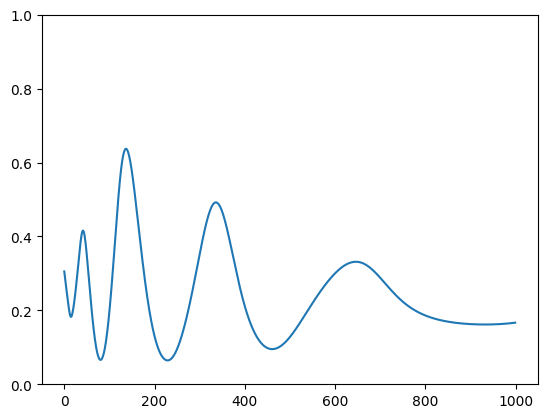

In [108]:
plt.plot(range(len(losses)), losses)
plt.ylim([0, 1])  # Set the maximum y-axis value
plt.show()